In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as tsa
import statsmodels.tsa.arima as arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

from arch import arch_model
import scipy.stats as stats

## Trend, Seasonality, and Residuals

In [14]:
INDPROD_TICKER = 'IPGMFN'# industrial production ticker
START_MONTH = '1988-12'#sock data start month
END_MONTH = '2023-12' #sock data end month

In [15]:
# getting economic indicator data
indprod = pdr.DataReader(INDPROD_TICKER, 'fred', START_MONTH, END_MONTH).squeeze().dropna()
indprod.head()

DATE
1988-12-01    57.2374
1989-01-01    57.9230
1989-02-01    58.3753
1989-03-01    58.3446
1989-04-01    59.2339
Name: IPGMFN, dtype: float64

In [16]:
components = tsa.seasonal_decompose(indprod, model='additive') # components combined in an additive, linear model

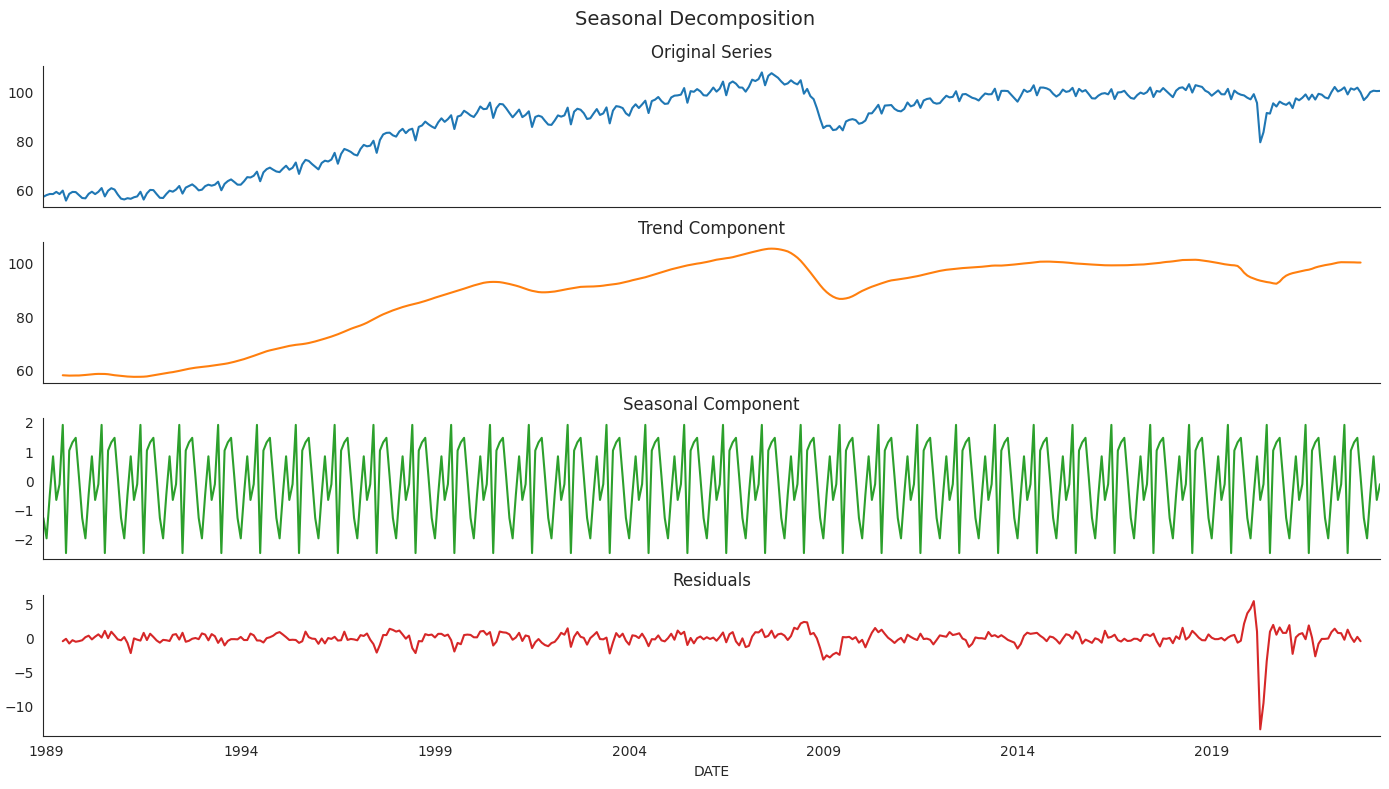

In [17]:
ts = (indprod.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [18]:
# take logarithm of indprod
indprod_log = np.log(indprod)
# seasonal differencing
indprod_log_diff = indprod_log.diff(12).dropna()

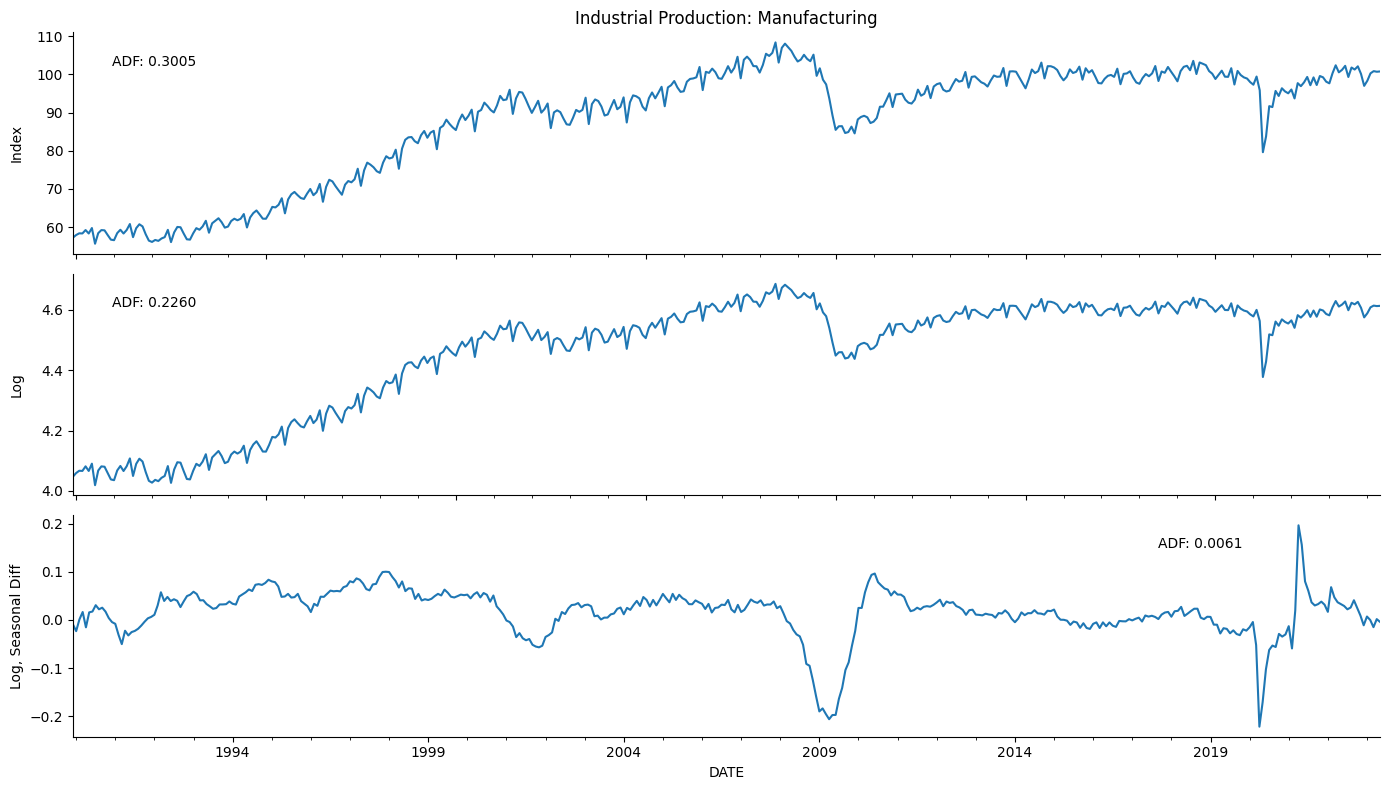

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))


indprod.plot(ax=axes[0],title='Industrial Production: Manufacturing')
axes[0].text(x=.03, y=.85,
                s=f'ADF: {tsa.adfuller(indprod)[1]:.4f}',
                transform=axes[0].transAxes)
axes[0].set_ylabel('Index')

indprod_log.plot(ax=axes[1], sharex=axes[1])
axes[1].text(x=.03, y=.85,
                s=f'ADF: {tsa.adfuller(indprod_log.dropna())[1]:.4f}',
                transform=axes[1].transAxes)
axes[1].set_ylabel('Log')

indprod_log_diff.plot(ax=axes[2], sharex=axes[2])
axes[2].text(x=.83, y=.85,
                s=f'ADF: {tsa.adfuller(indprod_log_diff.dropna())[1]:.4f}',
                transform=axes[2].transAxes)
axes[2].set_ylabel('Log, Seasonal Diff')

sns.despine()
fig.tight_layout()
fig.align_ylabels(axes)

## Correlogram

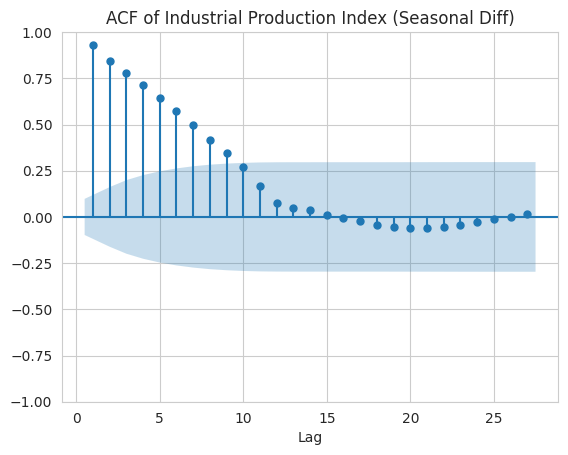

In [20]:
# plot ACF
with sns.axes_style('whitegrid'):
    plot_acf(x=indprod_log_diff, zero=False)
    plt.xlabel('Lag')
    plt.title('ACF of Industrial Production Index (Seasonal Diff)')

PACF shows significant positive correlation coefficients at lags 3, 13, and 25. It shows significant negative coefficients at lags 2, 4, 10, and 11.

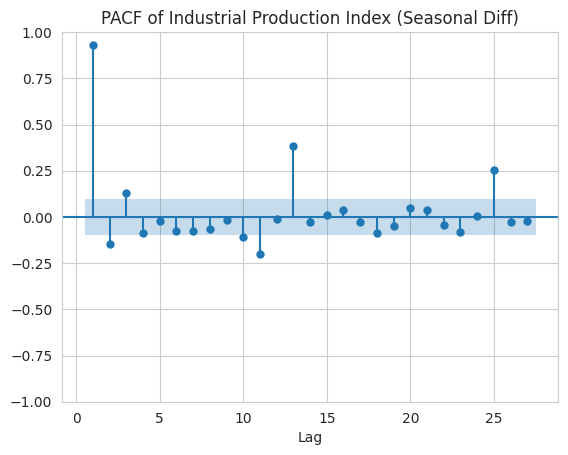

In [21]:
# plot PACF
with sns.axes_style('whitegrid'):
    plot_pacf(indprod_log_diff, zero=False, method='ywm')
    plt.xlabel('Lag')
    plt.title('PACF of Industrial Production Index (Seasonal Diff)')

## ARIMA(p,d,q) Model

In [ ]:
# from numpy.linalg import LinAlgError

# train_size = 150
# results = {}
# y_true = indprod_log_diff.iloc[train_size:]
# for p in range(5):
#     for q in range(5):
#         aic, bic = [], []
#         if p == 0 and q == 0:
#             continue
#         print(p, q)
#         convergence_error = stationarity_error = 0
#         y_pred = []
#         for T in range(train_size, len(indprod_log_diff)):
#             train_set = indprod_log_diff.iloc[T-train_size:T]
#             try:
#                 model = arima.model.ARIMA(endog=train_set, order=(p, 0, q)).fit()
#             except LinAlgError:
#                 convergence_error += 1
#             except ValueError:
#                 stationarity_error += 1

#             forecast = model.forecast(steps=1)
#             y_pred.append(forecast[0])
#             aic.append(model.aic)
#             bic.append(model.bic)

#         result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
#                   .replace(np.inf, np.nan)
#                   .dropna())

#         rmse = np.sqrt(mean_squared_error(y_true=result.y_true, y_pred=result.y_pred))

#         results[(p, q)] = [rmse,
#                            np.mean(aic),
#                            np.mean(bic),
#                            convergence_error,
#                            stationarity_error]

In [ ]:
arima_results = pd.DataFrame(results).T
arima_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arima_results.index.names = ['p', 'q']
arima_results.sort_values(by=['RMSE', 'BIC'])

In [ ]:
arima_results.sort_values(by=['BIC', 'RMSE'])

### AR(1) vs ARIMA(1,0,0)

In [23]:
arima100 = arima.model.ARIMA(endog=indprod_log_diff, order=(1, 0, 0)).fit() # equivalent to AR(1)
print(arima100.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  402
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1034.751
Date:                Wed, 12 Jul 2023   AIC                          -2063.502
Time:                        00:00:42   BIC                          -2051.512
Sample:                    12-01-1989   HQIC                         -2058.755
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0148      0.014      1.052      0.293      -0.013       0.042
ar.L1          0.9293      0.014     66.748      0.000       0.902       0.957
sigma2         0.0003   5.37e-06     63.059      0.0

C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


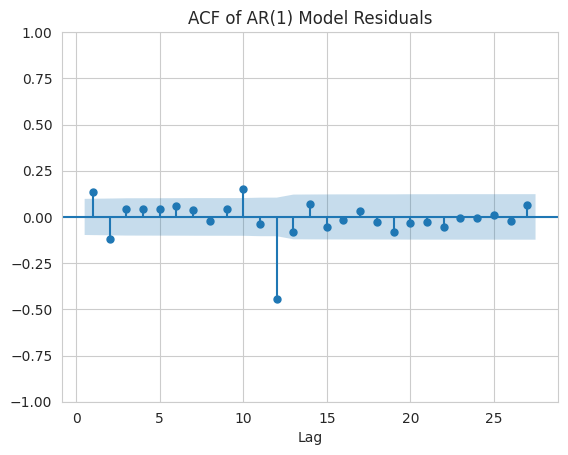

In [24]:
# plot ACF
with sns.axes_style('whitegrid'):
    plot_acf(x=arima100.resid, zero=False)
    plt.xlabel('Lag')
    plt.title('ACF of AR(1) Model Residuals')

The ACF of residuals shows significant correlation coefficients at lags 1, 2, 10, and 12, which supports the conclusion that they are not White Noise.

### AR(4) or ARIMA(4,0,0)

In [25]:
arima400 = arima.model.ARIMA(endog=indprod_log_diff, order=(4, 0, 0)).fit() # equivalent to AR(1)
print(arima400.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  402
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1043.862
Date:                Wed, 12 Jul 2023   AIC                          -2075.725
Time:                        00:00:52   BIC                          -2051.746
Sample:                    12-01-1989   HQIC                         -2066.231
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0150      0.014      1.039      0.299      -0.013       0.043
ar.L1          1.0947      0.021     52.212      0.000       1.054       1.136
ar.L2         -0.3048      0.035     -8.593      0.0

C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


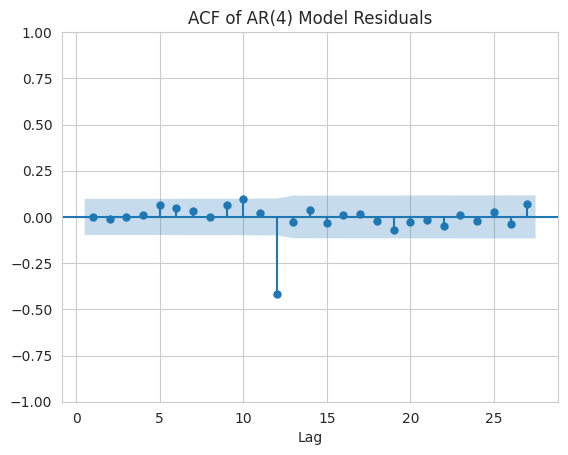

In [26]:
# plot ACF
with sns.axes_style('whitegrid'):
    plot_acf(x=arima400.resid, zero=False)
    plt.xlabel('Lag')
    plt.title('ACF of AR(4) Model Residuals')

The ACF of residuals shows significant correlation coefficients at lags 10 and 12. Considering the Ljung-Box Test result, having significant correlations at 2 lags is not enough to conclude that the residuals are not White Noise.

## Illustrating Market Volatility

In [27]:
TICKER = 'SPY' # Stock Ticker symbol
START_DATE = '2013-06-01' # Stock data start date
END_DATE = '2023-06-01' # Stock data end date

# Store price details into a variable
stockPx = yf.download(TICKER, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SPY Daily Log Returns'}, xlabel='Date', ylabel='Log Return'>

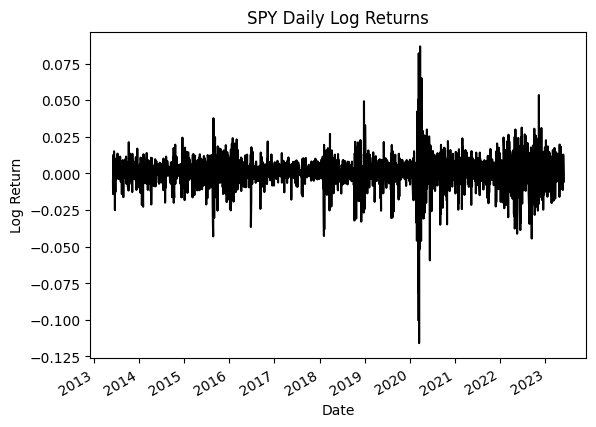

In [28]:
stockPxAj = stockPx['Adj Close'] # index adjusted close price column
# Covert stock price to log returns
stockLogRet = np.log(stockPxAj).diff().dropna() # calculate log returns and drop null values
# Time plot of stock log returns
stockLogRet.plot(title = TICKER + ' Daily Log Returns', ylabel = 'Log Return', color = 'k')

## GARCH(p,q) Model (normal)

In [ ]:
# trainsize = 5 * 252  # 5 years
# data = stockLogRet.clip(lower=stockLogRet.quantile(.05), upper=stockLogRet.quantile(.95)) # winsorize data
# T = len(stockLogRet) # total series length
# results = {}
# for p in range(1, 5):
#     for q in range(1, 5):
#         aic, bic = [], []
#         print(f'{p} | {q}')
#         result = []
#         for s, t in enumerate(range(trainsize, T-1)):
#             train_set = data.iloc[s: t]
#             test_set = data.iloc[t+1]  # 1-step ahead forecast
#             model = arch_model(y=train_set, mean='zero', p=p, q=q).fit(disp='off') # disp="off" to not print optimization result
#             forecast = model.forecast(horizon=1)
#             aic.append(model.aic)
#             bic.append(model.bic)
#             mu = forecast.mean.iloc[-1, 0]
#             var = forecast.variance.iloc[-1, 0]
#             result.append([(test_set-mu)**2, var])
#         df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        
#         rmse = np.sqrt(mean_squared_error(y_true=df.y_true, y_pred=df.y_pred))

#         results[(p, q)] = [rmse,
#                            np.mean(aic),
#                            np.mean(bic)]

In [ ]:
garch_results_norm = pd.DataFrame(results).T
garch_results_norm.columns = ['RMSE', 'AIC', 'BIC']
garch_results_norm.index.names = ['p', 'q']
garch_results_norm.sort_values(by=['RMSE', 'BIC'])

### GARCH with Student-t Innovations

In [ ]:
# trainsize = 5 * 252  # 5 years
# data = stockLogRet.clip(lower=stockLogRet.quantile(.05), upper=stockLogRet.quantile(.95)) # winsorize data
# T = len(stockLogRet) # total series length
# results = {}
# for p in range(1, 5):
#     for q in range(1, 5):
#         aic, bic = [], []
#         print(f'{p} | {q}')
#         result = []
#         for s, t in enumerate(range(trainsize, T-1)):
#             train_set = data.iloc[s: t]
#             test_set = data.iloc[t+1]  # 1-step ahead forecast
#             model = arch_model(y=train_set, mean='zero', p=p, q=q, dist = 't').fit(disp='off') # disp="off" to not print optimization result
#             forecast = model.forecast(horizon=1)
#             aic.append(model.aic)
#             bic.append(model.bic)
#             mu = forecast.mean.iloc[-1, 0]
#             var = forecast.variance.iloc[-1, 0]
#             result.append([(test_set-mu)**2, var])
#         df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        
#         rmse = np.sqrt(mean_squared_error(y_true=df.y_true, y_pred=df.y_pred))

#         results[(p, q)] = [rmse,
#                            np.mean(aic),
#                            np.mean(bic)]

In [ ]:
garch_results_t = pd.DataFrame(results).T
garch_results_t.columns = ['RMSE', 'AIC', 'BIC']
garch_results_t.index.names = ['p', 'q']
garch_results_t.sort_values(by=['RMSE', 'BIC'])

### GARCH with Generalized Error Innovations

In [ ]:
# trainsize = 5 * 252  # 5 years
# data = stockLogRet.clip(lower=stockLogRet.quantile(.05), upper=stockLogRet.quantile(.95)) # winsorize data
# T = len(stockLogRet) # total series length
# results = {}
# for p in range(1, 5):
#     for q in range(1, 5):
#         aic, bic = [], []
#         print(f'{p} | {q}')
#         result = []
#         for s, t in enumerate(range(trainsize, T-1)):
#             train_set = data.iloc[s: t]
#             test_set = data.iloc[t+1]  # 1-step ahead forecast
#             model = arch_model(y=train_set, mean='zero', p=p, q=q, dist = 'ged').fit(disp='off') # disp="off" to not print optimization result
#             forecast = model.forecast(horizon=1)
#             aic.append(model.aic)
#             bic.append(model.bic)
#             mu = forecast.mean.iloc[-1, 0]
#             var = forecast.variance.iloc[-1, 0]
#             result.append([(test_set-mu)**2, var])
#         df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        
#         rmse = np.sqrt(mean_squared_error(y_true=df.y_true, y_pred=df.y_pred))

#         results[(p, q)] = [rmse,
#                            np.mean(aic),
#                            np.mean(bic)]

In [ ]:
garch_results_ged = pd.DataFrame(results).T
garch_results_ged.columns = ['RMSE', 'AIC', 'BIC']
garch_results_ged.index.names = ['p', 'q']
garch_results_ged.sort_values(by=['RMSE', 'BIC'])

## Evaluate Best Model

In [29]:
stockLogRetWin = stockLogRet.clip(lower=stockLogRet.quantile(.05), upper=stockLogRet.quantile(.95)) # winsorize data

### GARCH(1,1) with Generalized Error Innovation

In [30]:
garch11_ged = arch_model(y=stockLogRetWin, mean='zero', p=1, q=1, dist = 'ged').fit(disp='off')
print(garch11_ged.summary())

                             Zero Mean - GARCH Model Results                              
Dep. Variable:                          Adj Close   R-squared:                       0.000
Mean Model:                             Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:                8740.28
Distribution:      Generalized Error Distribution   AIC:                          -17472.6
Method:                        Maximum Likelihood   BIC:                          -17449.2
                                                    No. Observations:                 2516
Date:                            Wed, Jul 12 2023   Df Residuals:                     2516
Time:                                    00:01:58   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------

C:\Users\user\anaconda3\anaconda3-20230301\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.527e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [31]:
# compute standardized residuals (innovations)
std_resid = garch11_ged.resid / garch11_ged.conditional_volatility

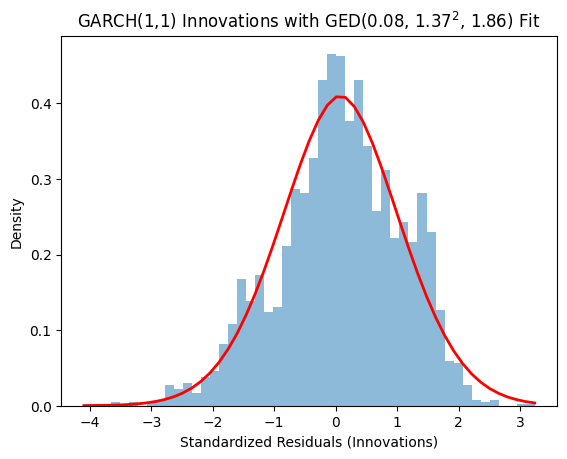

In [32]:
# Fit GED Distribution Curve
fig = plt.figure()
shape_ged, loc_ged, scale_ged = stats.gennorm.fit(std_resid) # shape, location, and scale estimates
ax1 = fig.add_subplot(111
                      , title= "GARCH(1,1) Innovations with GED("
                          +str(round(loc_ged, 2))
                          +', '+str(round(scale_ged, 2))+"$^{2}$"
                          +', '+ str(round(shape_ged, 2))+") Fit"
                      , xlabel='Standardized Residuals (Innovations)'
                      , ylabel='Density')
_, bins, _= ax1.hist(std_resid, bins=50, density=1, alpha=0.5) # Innovations histogram
fitted_ged = stats.gennorm.pdf(bins, shape_ged, loc_ged, scale_ged) # generate theoretical GED pdf
ax1.plot(bins, fitted_ged, label='GED PDF', color = 'r', lw=2.) # plot theoretical GED pdf over histogram

Text(0, 0.5, 'Sample quantiles')

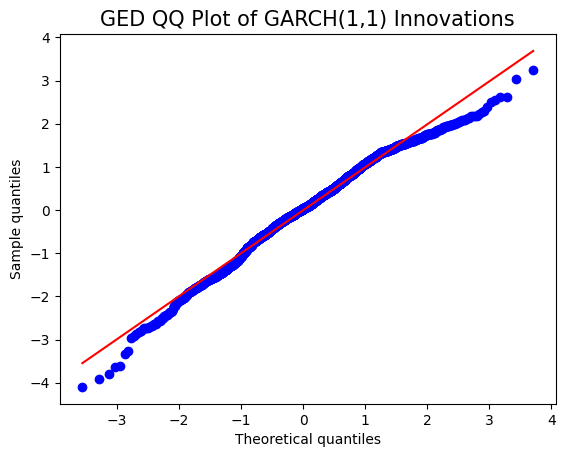

In [33]:
# Fit GED QQ Plot
fig = plt.figure()
qq_ged = stats.probplot(std_resid, dist = 'gennorm', sparams= (shape_ged, loc_ged, scale_ged), plot = plt, fit = True)
plt.title('GED QQ Plot of GARCH(1,1) Innovations', size=15)
plt.ylabel('Sample quantiles')

In [34]:
jarque_bera_test = stats.jarque_bera(std_resid)
jarque_bera_test.pvalue

4.660943506154078e-14

In [35]:
ljung_box_test1 = sm.stats.acorr_ljungbox(std_resid, lags = 25, return_df=True)
ljung_box_test1.lb_pvalue

1     0.142856
2     0.263887
3     0.414102
4     0.410702
5     0.496741
6     0.617424
7     0.464014
8     0.524886
9     0.611271
10    0.642230
11    0.683499
12    0.662524
13    0.691999
14    0.743422
15    0.573884
16    0.596096
17    0.621230
18    0.598151
19    0.644622
20    0.642184
21    0.511328
22    0.331678
23    0.383944
24    0.437279
25    0.393346
Name: lb_pvalue, dtype: float64

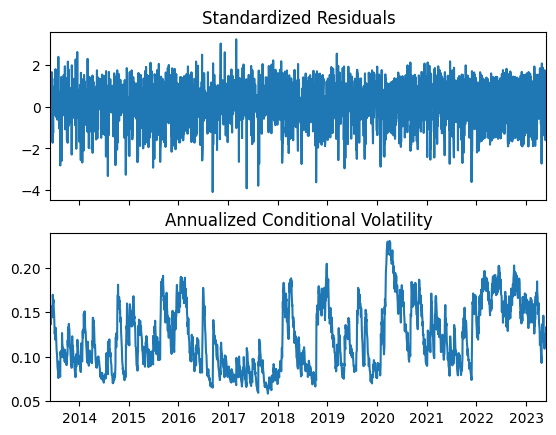

In [36]:
fig = garch11_ged.plot(annualize='D')

In [37]:
ljung_box_test2 = sm.stats.acorr_ljungbox(std_resid**2, lags = 50, return_df=True)
ljung_box_test2.lb_pvalue

1     0.218911
2     0.006754
3     0.018590
4     0.021151
5     0.034531
6     0.060451
7     0.010107
8     0.016712
9     0.026625
10    0.041936
11    0.015869
12    0.013502
13    0.006990
14    0.004870
15    0.002918
16    0.004684
17    0.007281
18    0.008916
19    0.013140
20    0.018951
21    0.024902
22    0.029708
23    0.030510
24    0.036021
25    0.032144
26    0.021159
27    0.026910
28    0.030484
29    0.039720
30    0.047965
31    0.054745
32    0.049126
33    0.060992
34    0.050317
35    0.057037
36    0.069103
37    0.084972
38    0.101591
39    0.083694
40    0.051701
41    0.059372
42    0.069098
43    0.079957
44    0.079593
45    0.092651
46    0.109806
47    0.121843
48    0.142800
49    0.166282
50    0.189410
Name: lb_pvalue, dtype: float64

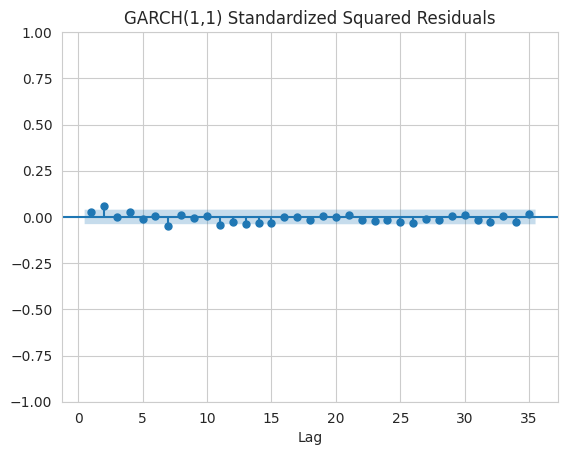

In [38]:
# plot ACF
with sns.axes_style('whitegrid'):
    plot_acf(x=std_resid**2, zero=False)
    plt.xlabel('Lag')
    plt.title('GARCH(1,1) Standardized Squared Residuals')

All in all, the GARCH(1,1) model with GED innovation matches all the criteria of having the optimal p, q parameters are sufficed except the last one, that is,it shows correlation in its standardized squared residuals. This means that there is remaining information in the data that the model fails to capture.

One solution for resolving this is to incorporate additional features into the model. For example, conditional correlation models (e.g., multivariate GARCH models) can be used to capture cross-sectional dependence in the residuals or squared residuals.